# Introduction
This notebook isn't predictions of epidemic development but an attempt to answer if we have an uptrend, permanent or downtrend trend in different time horizons by using technical indicators.

## ETL

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Import data and add one more column 'day' as index.

In [2]:
df = pd.read_csv('poland_daily.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df['day'] = range(1, len(df) + 1)
df.head()

,date,new_infection,new_deaths,day
0,2020-04-03,1,0,1
1,2020-05-03,0,0,2
2,2020-06-03,4,0,3
3,2020-07-03,1,0,4
4,2020-08-03,5,0,5


## GMAA
The Guppy Multiple Moving Average (GMMA) is a technical indicator that identifies changing trends, breakouts, and trading opportunities in the price of an asset by combining two groups of moving averages (MA) with different time periods. 

In our case we can map it to:
* When the short-term group of averages moves above the longer-term group, it indicates an epidemic uptrend could be emerging.

* When the short-term group falls below the longer-term group of MAs, an epidemic downtrend could be starting.

* When there is lots of separation between the MAs, this helps confirm the epidemic trend in the current direction.

### Prepare simple moving averages

In [3]:
sma = {}
sma['yellow'] = [2, 3, 4, 5, 6, 7]
sma['orange'] = [9, 10, 11, 12, 13]
sma['blue']   = [15, 17, 19, 21, 23]
sma['green']  = [25, 27, 29, 31, 33]
sma['red']    = [35, 37, 40, 43]

In [4]:
for (color) in sma:
    for window_size in sma[color]:
        sma_name = 'SMA_' + str(window_size)
        df[sma_name] = df.iloc[:,1].rolling(window=window_size).mean()

## RSI
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.

In our case we can map it to:
* RSI > 70 - it can indicate an epidemic downtrend could be emerging.
* RSI < 30 - it can indicate an epidemic uptrend could be emerging.




In [5]:
def rsi(data, window):
    delta = data.diff()
    up_days = delta.copy()
    up_days[delta<=0]=0.0
    down_days = abs(delta.copy())
    down_days[delta>0]=0.0
    RS_up = up_days.rolling(window).mean()
    RS_down = down_days.rolling(window).mean()
    return 100-100/(1+RS_up/RS_down)

rsi_window_size = 14
rsi_values = rsi(df['new_infection'], rsi_window_size)

## Bollinger Bands

In [6]:
def bol(data, period, deviation):
    sma = data.rolling(window=period).mean()
    std = data.rolling(window=period).std()
    up_bol = sma + deviation * std
    down_bol = sma - deviation * std
    
    d = {'sma': sma, 'up_bol': up_bol, 'down_bol': down_bol}
    return pd.DataFrame(data=d)

period = 14
deviation = 2
bol = bol(df['new_infection'], period, deviation)

## Plot calculated technical indicators

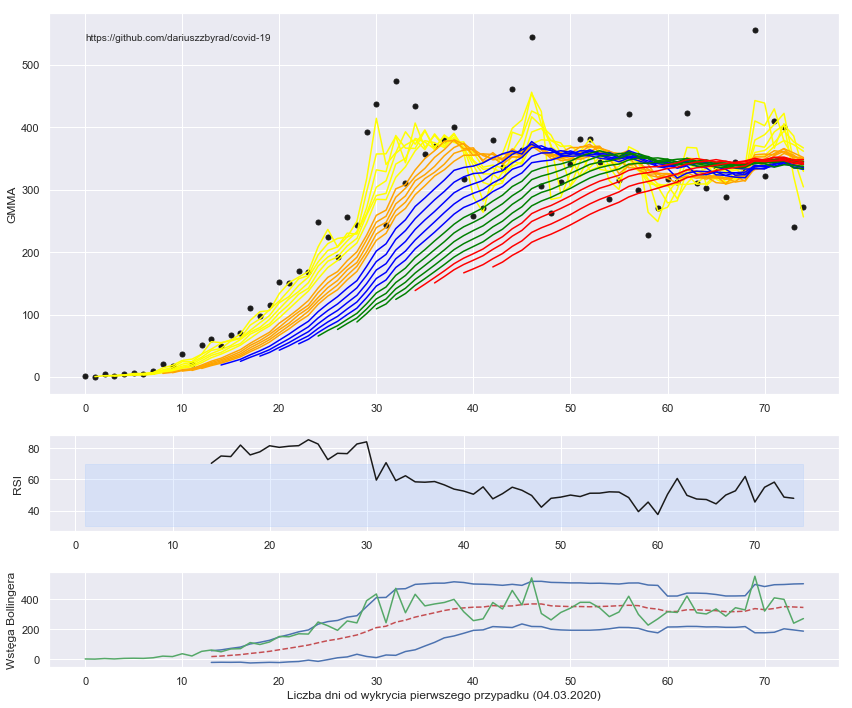

In [7]:
import seaborn as sns; sns.set()

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=[12,10], gridspec_kw={'height_ratios': [4, 1, 1]})

ax0.plot(df['new_infection'], 'ko',label='Dzienny przyrost', markersize=5)
for (color) in sma:
    for window_size in sma[color]:
        sma_name = 'SMA_' + str(window_size)
        ax0.plot(df[sma_name], color)
ax0.set_ylabel('GMMA')
ax0.text(0, 540, 'https://github.com/dariuszzbyrad/covid-19', fontsize=10)

ax1.plot(rsi_values, 'k')
ax1.fill_between(df['day'], y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_ylabel('RSI')

ax2.plot(bol['up_bol'], 'b-')
ax2.plot(bol['sma'], 'r--')
ax2.plot(bol['down_bol'], 'b-')
ax2.plot(df['new_infection'], 'g-')
ax2.set_xlabel('Liczba dni od wykrycia pierwszego przypadku (04.03.2020)')
ax2.set_ylabel('Wstęga Bollingera')

fig.tight_layout()
plt.show()
#fig.savefig('figure.pdf')